# Modeling Building<br/>*Stacking and VotingClassifiers*

## Goals
1. Describe Ensemble
2. Describe Stacking Algorithm
3. Custom Code a Stacking Classifier
4. Use Stacking Classifier and Analyze Results
5. Use VotingClassifier and Analyze Results
6. Custom Code a Forest of DecisionTrees
7. Summary of Results

## Ensemble Description
An *ensemble* makes use of multiple models to improve predictions.

An ensemble is like a group of experts. Each expert can choose the best option as they see it, the votes can be tallied up, and the option with the most votes is selected.  This combines the expertise of many people resulting in a better decision.

In the above example, each expert is analogous to a *base learner*.  And the method of combining is voting.

For an ensemble to work well:
* each expert should be better at predicting than random chance
* the experts should not always agree with each other

Scikit Learn has several ensemble estimators: [Scikit Learn Ensembles](https://scikit-learn.org/stable/modules/ensemble.html)

Some types of ensembles include:
1. [Bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) an example of which is a Random Forest
2. [Stacking](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking) a custom stacking estimator will be coded below
3. [Boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning)) an example of which is [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)

Any type of model can be used as a *base learner*, including an ensemble.

In Stacking, the predictions from the base learners are fed into another model, the *meta learner*, to create the final prediction.

In the Stacking classifier below, several Scikit Learn classifiers as well as XGBoostClassifier will be used as the base learners.  The meta-learner will be LogisticRegression.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt

In [2]:
# Version Information
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)
!lsb_release -d

python:      3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy:       1.16.4
pandas:      0.24.2
matplotlib:  3.1.0
seaborn:     0.9.0
sklearn:     0.21.2
Description:	Ubuntu 18.04.2 LTS


In [3]:
# Scikit Learn imports
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer

# conda install py-xgboost
from xgboost import XGBClassifier

In [4]:
# explictly enable and import new iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Performance of Base Learners
Initially, the base learners will use default values for all hyperparameters.

As demonstrated in the previous notebook in this series, comparing models is best done with 10-Repeated 2-Fold Cross Validation.

Final model evaluation can be done with 10-Repeated 10 Fold Cross Validation.

The data encoding, get_Xy_v6(), and data transformations, get_ct_v5(), are as per previous notebooks.

In [5]:
# get the X predictor matrix and the y target vector
X, y = tt.get_Xy_v6()

# instantiate a few estimators using defaults
lr  = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
xgb = XGBClassifier(objective='binary:logistic', random_state=48)
svm = SVC(gamma='auto', probability=True)
nn  = MLPClassifier(max_iter=2000, random_state=101)

# apply the ColumnTransform logic used in previous notebooks
cols, ct = tt.get_ct_v5()
lr_pipe = Pipeline([('ct', ct), ('lr', lr)])
knn_pipe = Pipeline([('ct', ct), ('knn', knn)])
# xgb seems to work better without the data preprocessing
svm_pipe = Pipeline([('ct', ct), ('svm', svm)])
nn_pipe = Pipeline([('ct', ct), ('nn', nn)])

base_learners = [lr_pipe, knn_pipe, xgb, svm_pipe, nn_pipe]

In [6]:
# Cross Validation Generators used in this Notebook
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, 
                                    random_state=108)
cv_select_quick = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, 
                                          random_state=108)
cv_predict = StratifiedKFold(n_splits=10, random_state=1001)

In [7]:
# Evaluate the Accuracy of each base learner
for base_learner in base_learners:
    if hasattr(base_learner, 'steps'):
        name = base_learner.steps[1][0].upper()
    else:
        name = base_learner.__class__.__name__

    scores  = cross_val_score(base_learner,  X, y, scoring='accuracy', 
                              cv=cv_select)
    print(f'{name:13} Score: {scores.mean():.3f} +/- {scores.std():.3f}')

LR            Score: 0.830 +/- 0.013
KNN           Score: 0.806 +/- 0.015
XGBClassifier Score: 0.823 +/- 0.013
SVM           Score: 0.831 +/- 0.013
NN            Score: 0.816 +/- 0.016


## Scikit Learn Methods used in Stacking

### *cross_val_score* and *cross_val_predict*
It is helpful to understand the relationship between these two methods.

cross_val_score uses cross validation to predict on each of K test folds, scores each prediction, and returns each of the K scores.

cross_val_predict uses cross validation to predict on each of K test folds and returns len(X_train) predictions.

cross_val_score will call the estimator's predict or predict_proba method, depending upon the scoring metric.

cross_val_predict will call the estimator's predict or predict_proba method, depending upon the method argument passed to it.

The predictions from cross_val_predict can be scored in any way, including the same way that they are scored with cross_val_score.

### Use cross_val_predict to get cross_val_scores

In [8]:
# Part 1: Accuracy -- estimator's predict method is called
acc_scores = cross_val_score(lr_pipe, X, y, 
                             scoring='accuracy', cv=cv_predict)

acc_scores2 = []
predictions = cross_val_predict(lr_pipe, X, y, 
                                cv=cv_predict, method='predict')

for train_index, test_index in cv_predict.split(X, y):
    fold_score = accuracy_score(y.iloc[test_index], 
                                predictions[test_index])
    acc_scores2.append(fold_score)

# verify scores are the same
print((acc_scores == acc_scores2).all())

True


In [9]:
# Part 2: Log Loss -- estimator's predict_proba method is called
logloss_scores = cross_val_score(lr_pipe, X, y, 
                                 scoring='neg_log_loss', cv=cv_predict)

logloss_scores2 = []
predictions = cross_val_predict(lr_pipe, X, y,
                                cv=cv_predict, method='predict_proba')

for train_index, test_index in cv_predict.split(X, y):
    fold_score = -log_loss(y.iloc[test_index], 
                           predictions[test_index])
    logloss_scores2.append(fold_score)

# verify results are the same
print((logloss_scores == logloss_scores2).all())

True


## Stacking

### Algorithm  
1. fit on train
   * create training meta-features using base learners with cross_val_predict
   * fit meta-learner on training meta-features
   * fit base learners (for next step)
2. predict on test
   * create test meta-features using fitted base learners
   * create predictions using fitted meta-learner on test meta-features

### Creating Meta Features 
In general, the model building process should not have a step which both fits and predicts on the same data.  In step 1 above, had the training meta-features been created by fitting the base learners on the training data and then using those base learners to predict on that same training data, this would have been overfitting.

Instead the meta level features in step 1 above should use "cross validated predictions".  Here is a quote from Scikit Learn on [cross_val_predict](https://scikit-learn.org/stable/modules/cross_validation.html#obtaining-predictions-by-cross-validation)
> The function cross_val_predict is appropriate for:  
* Visualization of predictions obtained from different models.  
* Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods. 

An good alternative description of the Stacking algorithm, which also describes the use of cross validated predictions for meta level features, can be found at:  
[Super Learner Algorithm](https://h2o-release.s3.amazonaws.com/h2o/rel-ueno/2/docs-website/h2o-docs/data-science/stacked-ensembles.html#super-learner-algorithm)

### Why Build a Custom Stacking Estimator
There are several good libraries available for stacking such as [mlxtend](http://rasbt.github.io/mlxtend/) and [mlens](https://mlens.readthedocs.io/en/0.1.x/).

As of May 2019, mlxtend did not work with ColumnTransformer (introduced in September of 2018).  ColumnTransformer, or  [sklearn-pandas](https://github.com/scikit-learn-contrib/sklearn-pandas) is necessary to preprocess input features using a clean work flow.  All previous notebooks in this series used ColumnTransformer.

Creating a custom classifier allows for continued use of ColumnTransformer, and shows how easy the basics of building a custom classifier are.

A good approach to software development is to first create a simple working example, and then abstract that logic into an object or function.  That is the approach taken here.

### Stacking Example

Above algorithm in six steps:
1. create train/test split
2. creating training meta-features
3. fit meta-learner to training meta-features
4. fit base learners
5. create test meta-features
6. predict and evaluate fitted meta-learner on test meta-features

#### 1. Train/Test Split
Key Points:  
* Train/Test split used for illustration.  Cross Validation is better for this data set.

In [10]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.333, random_state=1001)

#### 2. Create Training Meta-Features
Key points:
* use cross_val_predict on training data to avoid overfitting
* for classification, use predict_proba to provide more information to the meta-learner

In [11]:
# predict_proba outputs [probability NotSurvived, probability Survived]
# select the 2nd column only
p1_train = cross_val_predict(lr_pipe, X_train, y_train, cv=cv_predict, 
                             method='predict_proba')[:, 1]
p2_train = cross_val_predict(svm_pipe, X_train, y_train, cv=cv_predict, 
                             method='predict_proba')[:, 1]

# combine features into meta-features matrix
meta_train = np.column_stack((p1_train, p2_train))

#### 3. Fit Meta Learner

In [12]:
meta_learner = LogisticRegression(solver='liblinear')
meta_learner.fit(meta_train, y_train);

#### 4. Fit Base Learners

In [13]:
# fit base learners on all of train
lr_pipe.fit(X_train, y_train)
svm_pipe.fit(X_train, y_train);

#### 5. Create Test Meta Features

In [14]:
# predict probability of survived
p1_test= lr_pipe.predict_proba(X_test)[:, 1]
p2_test = svm_pipe.predict_proba(X_test)[:, 1]

# combine features into meta-features matrix
meta_test = np.column_stack((p1_test, p2_test))

#### 6. Predict and Evaluate

In [15]:
meta_pred = meta_learner.predict(meta_test)
score = accuracy_score(y_test, meta_pred)
np.round(score, 3)

0.832

#### Above Score May Have Strong Bias and Variance
The above score was computed from a single train/test split.  The Titanic data set is small, so both the train and test sets are small.  A small train set my cause a large score bias.  A small test split may cause a large score variance.  Cross Validation should be used instead.

## Create Custom Stacking Classifier

The custom Stacking classifier created below:
* will work with ColumnTransformer
* will work with cross_val_score
* will not work with GridSearchCV
* will not use parallelization to speed up operation
* will not report usage errors

See: [Rolling your own estimator](https://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator)

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin
class StackedClassifier(BaseEstimator, ClassifierMixin):
    '''Minimal Stacking Classifier
    
       Uses predict_proba for level 1 meta features.
    '''

    def __init__(self, base_learners, meta_learner, cv):
        self.base_learners = base_learners
        self.meta_learner = meta_learner
        self.cv = cv

    def fit(self, X, y):      
        
        # Create Training Features
        train_cols = []
        for base_learner in self.base_learners:
            preds = cross_val_predict(base_learner, X, y, cv=self.cv,
                                      method='predict_proba')[:, 1]
            train_cols.append(preds)
        X_meta_train = np.column_stack(train_cols)
        
        # fit meta learner on train
        self.meta_learner.fit(X_meta_train, y)
        
        # fit the base learners on the entire training data
        for base_learner in self.base_learners:
            base_learner.fit(X, y)

        # Return the classifier
        return self

    def predict(self, X):
        
        # Create Test Features
        test_cols = []
        for base_learner in self.base_learners:
            preds = base_learner.predict_proba(X)[:, 1]
            test_cols.append(preds)
        X_meta_test = np.column_stack(test_cols)
        
        predictions = self.meta_learner.predict(X_meta_test)

        return predictions

### Experiment with Custom Stacked Classifier
These experiments use LogisticRegression as the meta learner.

Per the above, the individual models scored:  
LR            Score: 0.830 +/- 0.013  
KNN           Score: 0.806 +/- 0.015  
XGBClassifier Score: 0.823 +/- 0.013  
SVM           Score: 0.831 +/- 0.013  
NN            Score: 0.816 +/- 0.016  

Ideally we would like to see a score better than the single best score above.

In [17]:
# Prepare the individual base learners

# Instantiate Estimators
lr  = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
xgb = XGBClassifier(objective='binary:logistic', random_state=48)
svm = SVC(gamma='auto', probability=True)
nn  = MLPClassifier(max_iter=2000, random_state=101)

# Get ColumnTransform Preprocessing Object
cols, ct = tt.get_ct_v5()

# Prepend Preprocessing to create Pipeline
lr_pipe = Pipeline([('ct', ct), ('lr', lr)])
knn_pipe = Pipeline([('ct', ct), ('knn', knn)])
# xgb seems to work better without the data preprocessing
svm_pipe = Pipeline([('ct', ct), ('svm', svm)])
nn_pipe = Pipeline([('ct', ct), ('nn', nn)])

#### Base Learners: LogitReg, KNN

In [18]:
base_learners = [lr_pipe, knn_pipe]
meta_learner = LogisticRegression(solver='liblinear')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.812 max:0.849
CV Mean Score: 0.831 +/- 0.013


#### Base Learners: LogitReg, SVM

In [19]:
base_learners = [lr_pipe, svm_pipe]
meta_learner = LogisticRegression(solver='liblinear')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.813 max:0.859
CV Mean Score: 0.833 +/- 0.014


#### Base Learners: LogitReg, SVM, XGB

In [20]:
base_learners = [lr_pipe, svm_pipe, xgb]
meta_learner = LogisticRegression(solver='liblinear')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.812 max:0.857
CV Mean Score: 0.831 +/- 0.012


#### Base Learners: LogitReg, SVM, KNN, XGB

In [21]:
base_learners = [lr_pipe, svm_pipe, knn_pipe, xgb]
meta_learner = LogisticRegression(solver='liblinear')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.816 max:0.857
CV Mean Score: 0.832 +/- 0.012


#### Base Learners: LogitReg, SVM, KNN, XGB, NeuralNetwork

In [22]:
base_learners = [lr_pipe, svm_pipe, knn_pipe, xgb, nn_pipe]
meta_learner = LogisticRegression(solver='liblinear')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.857
CV Mean Score: 0.831 +/- 0.012


### Analysis of Stacking Results
More experiments were tried than are presented above, but the above results are illustrative of what happened.

There was no improvement.

Above, both the base learners and the meta learner did not have their hyperparameters tuned.  This will be tried next.

## Optimize Base Learners

The base learners are being used to generate probabilities as meta-features for the meta learner.  For the meta learner to work well, these probabilities should be [calibrated](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html).

Unfortunately, just as there is too little data for a hold-out set for model evaluation, there is too little data for another hold-out set for probability calibration.  Calibration cannot be done here.

A possible alternative to calibrating the probabilities is to tune the base learner's hyperparameters such that the [Brier score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html) is optimized.  This was tried, but was found not to be as good as optimizing by accuracy.  The optimization by Brier score results are not shown here.

Ideally all the base learners and the meta-learner, would be optimized together.  An ensemble predicts well if its base learners are diverse, and this diversity is not captured when optimizing the base learners one at a time.  Unfortunately this is too computationally intensive.

Another type of ensemble, directly supported by Scikit Learn, is the VotingClassifier.  This is simpler than a Stacking classifier and will be tried later in this notebook.  It will also make use of the optimized base learners.

In [23]:
# from previous notebooks
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

##### **Logistic Regression**  
To be thorough, the saga solver will be used which allows for penalty='elasticnet'.  Elastic Net uses a combination of L1 and L2 regularization penalties.

In [24]:
lr  = LogisticRegression(solver='saga', penalty='elasticnet',
                         max_iter=5000)
lr_pipe_best = Pipeline([('ct', ct), ('lr', lr)])

params = {'lr__C': np.logspace(-2, 2, 20),
          'lr__l1_ratio': np.linspace(0, 1, 3)}
grid = GridSearchCV(estimator=lr_pipe_best, param_grid=params, 
                    scoring='accuracy', cv=cv_select)

grid.fit(X, y);

In [25]:
df_lr = tt.print_grid(grid, pandas=True)

Best: 0.832 +/- 0.014
lr__C: 3.359818286283781
lr__l1_ratio: 0.0


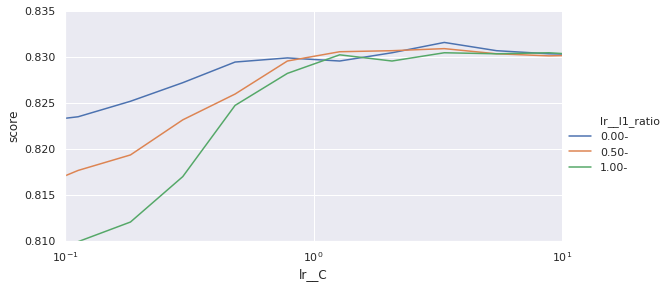

In [26]:
# workaround for Seaborn bug with hue=numeric-variable
# convert ratio to string and append a non-numeric character
df = df_lr.copy()
df['lr__l1_ratio'] = df_lr['lr__l1_ratio'].apply(lambda x: f'{x:.2f}-')

g = sns.relplot(x='lr__C', y='score', hue = 'lr__l1_ratio',
                height=4, aspect=2.0,
                data=df, ci=None, kind='line');

ax = g.axes[0, 0]
ax.set_xscale('log')
ax.set_xlim(.1, 10)
ax.set_ylim(.810, .835);

A local maxima is seen with l1_ratio=0, so the hyperparameter grid values are good.

An l1_ratio of 0 implies use of an L2 penalty only, which is the default for LogisticRegression.  Also, for this small dataset, liblinear converges faster than saga.  In the following, liblinear will be used.

In [27]:
# verify liblinear produces same result as above
best_c = grid.best_params_['lr__C']
lr  = LogisticRegression(solver='liblinear', C=best_c)
lr_pipe_best = Pipeline([('ct', ct), ('lr', lr)])

scores= cross_val_score(lr_pipe_best, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.812 max:0.859
CV Mean Score: 0.832 +/- 0.014


##### **Support Vector Machine** 

In [28]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

svm = SVC(gamma='auto', probability=True)
svm_pipe_best = Pipeline([('ct', ct), ('svm', svm)])

params = {'svm__C': np.logspace(2, 4, 3),
          'svm__gamma': np.logspace(-4, -1, 4)}

grid = GridSearchCV(estimator=svm_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

grid.fit(X, y);

In [29]:
df_svm = tt.print_grid(grid, pandas=True)

Best: 0.833 +/- 0.013
svm__C: 1000.0
svm__gamma: 0.001


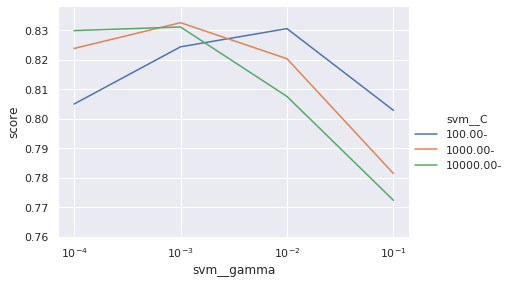

In [30]:
# workaround for Seaborn hue bug
df = df_svm.copy()
df['svm__C'] = df['svm__C'].apply(lambda x: f'{x:.2f}-')

g = sns.relplot("svm__gamma", "score", hue="svm__C", data=df,
                kind="line", height=4.0, aspect=1.5)
ax = g.axes[0,0]
ax.set_xscale('log')
ax.set_ylim(0.76, 0.838);

From the above, its possible that the local maxima for the green curve lies between .0001 and .001 and is higher than the local maxima for the orange curve.

Add a point between .0001 and .001 and rerun GridSearchCV.

In [31]:
params = {'svm__C': np.logspace(2, 4, 3),
          'svm__gamma': [.0001, .0005, .001, .01, .1]}

grid = GridSearchCV(estimator=svm_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

grid.fit(X, y);

In [32]:
df_svm = tt.print_grid(grid, pandas=True)

Best: 0.834 +/- 0.014
svm__C: 10000.0
svm__gamma: 0.0005


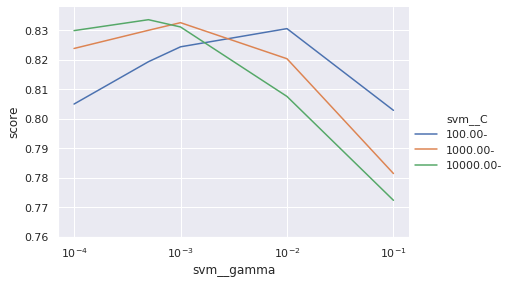

In [33]:
# workaround for Seaborn hue bug
df = df_svm.copy()
df['svm__C'] = df['svm__C'].apply(lambda x: f'{x:.2f}-')

g = sns.relplot("svm__gamma", "score", hue="svm__C", data=df,
                kind="line", height=4.0, aspect=1.5)
ax = g.axes[0,0]
ax.set_xscale('log')
ax.set_ylim(0.76, 0.838);

A higher score was found.  Although here the difference is insignificant, it is worthwhile to understand how to adjust the hyperparameter grid values to ensure that a local maxima is reached along each dimension.

When the slope along one dimension is nearly flat, and it is near the optimum value, then it may be that the plotted points fall on either side of the optimal point.  Adding a point in the flat section can help find the local optima.

##### **KNN**  

In [34]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

knn = KNeighborsClassifier()
knn_pipe_best = Pipeline([('ct', ct), ('knn', knn)])

params = {'knn__n_neighbors': [2, 3, 5, 8, 13, 21, 34, 55, 89],
          'knn__weights': ['uniform', 'distance'],
          'knn__p':[1, 2]}

grid = GridSearchCV(estimator=knn_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [35]:
df_knn = tt.print_grid(grid, pandas=True)

Best: 0.824 +/- 0.016
knn__n_neighbors: 13
knn__p: 1
knn__weights: uniform


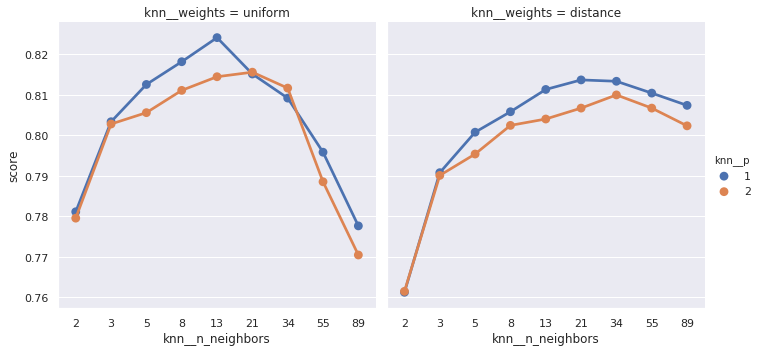

In [36]:
# sns.relplot, with the workaround, works well here too
g = sns.catplot("knn__n_neighbors", "score", "knn__p", 
                col="knn__weights", data=df_knn, kind="point")

In the above, weights='uniform' is clearly doing better than weights='distance'.

It's probably splitting hairs, but a better local maxima could be found by fixing weights='uniform' (to save computation time) and trying more values of n between about 10 and 15.

In [37]:
params = {'knn__n_neighbors': [10, 11, 12, 13, 14, 15],
          'knn__weights': ['uniform'],
          'knn__p':[1, 2]}

grid = GridSearchCV(estimator=knn_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

grid.fit(X, y);

In [38]:
df_knn = tt.print_grid(grid, pandas=True)

Best: 0.824 +/- 0.015
knn__n_neighbors: 12
knn__p: 1
knn__weights: uniform


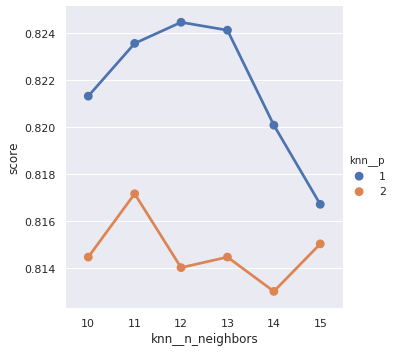

In [39]:
g = sns.catplot("knn__n_neighbors", "score", "knn__p", 
                data=df_knn, kind="point")

The difference between K=12 and K=13 is likely due to sampling variation, but as 12 is better, it might as well be used.

##### **XGB** 

In [40]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

xgb_best = XGBClassifier(objective='binary:logistic', random_state=48)

params = {'n_estimators': [100], 
          'learning_rate': [0.01, .02, .03, .04,
                            .05, .06, .07, .08],
          'max_depth': [5, 6, 7, 8, 9, 10, 11],
          'colsample_bytree': [1.0, 0.6, 0.5, 0.4]}
grid = GridSearchCV(estimator=xgb_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

grid.fit(X, y);

In [41]:
df_xgb = tt.print_grid(grid, pandas=True)

Best: 0.833 +/- 0.014
colsample_bytree: 0.5
learning_rate: 0.03
max_depth: 11
n_estimators: 100


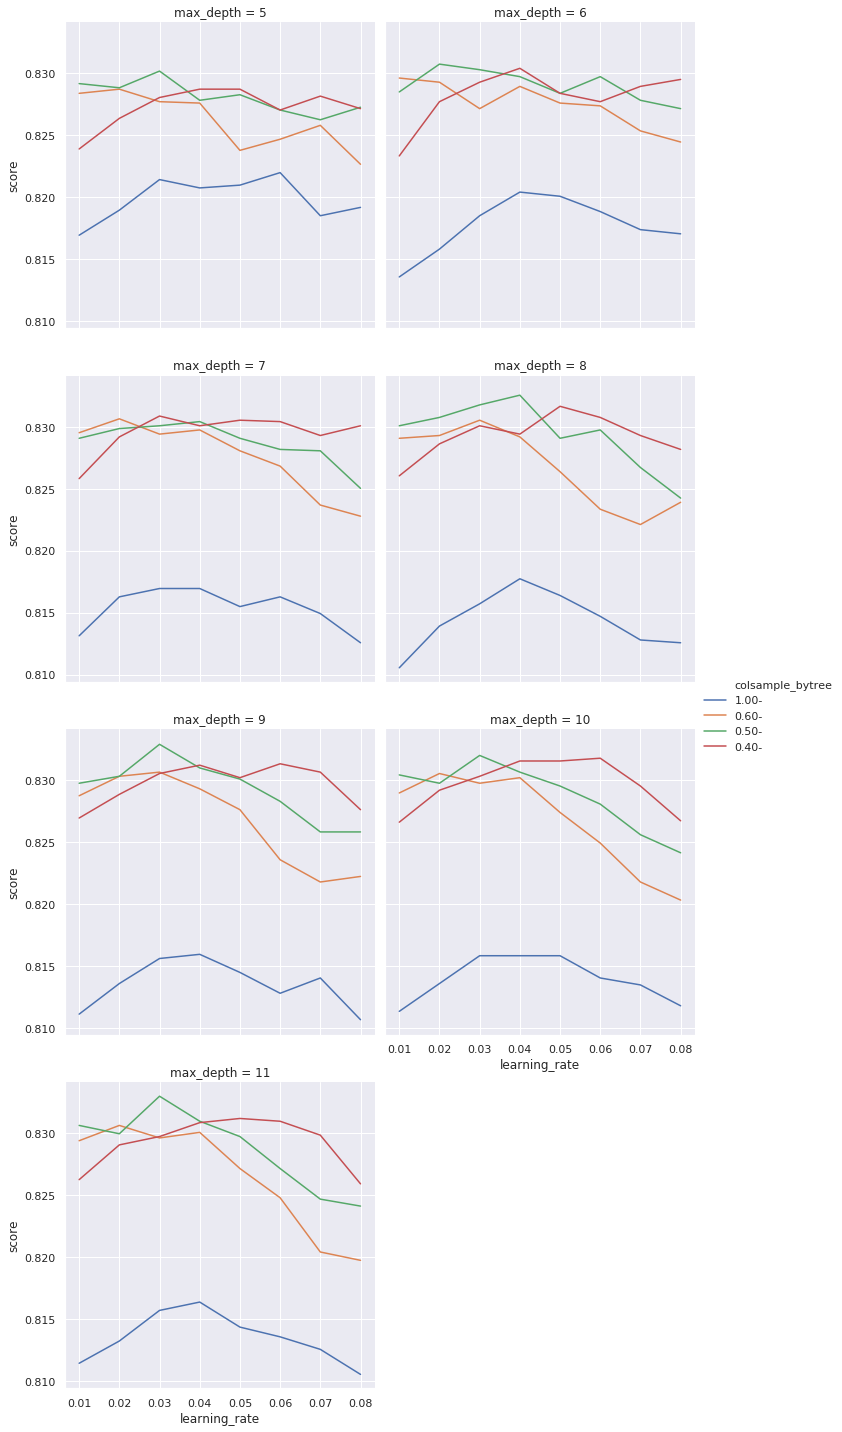

In [42]:
# workaround for Seaborn hue bug
df = df_xgb.copy()
df['colsample_bytree'] = \
    df['colsample_bytree'].apply(lambda x: f'{x:.2f}-')

g = sns.relplot("learning_rate", "score", "colsample_bytree", 
                col="max_depth", col_wrap=2, 
                data=df, kind="line", ci=None)

##### Examining the XGB Facet Plots
It appears a local maxima was reached along each dimension.  The grid values supplied to GridSearchCV are fine.  Use the values found by GridSearchCV.

#### **Neural Network** 
There are an infinite number of possibilities. Keras and other packages may be better.  Here, try a few with the Scikit Learn's Neural Network.

In [43]:
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1]

In [44]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

nn = MLPClassifier(max_iter=2000, random_state=909)
nn_pipe_best = Pipeline([('ct', ct), ('nn', nn)])

params = {'nn__hidden_layer_sizes':[(50,),(100,),(200,)],
          'nn__alpha':alpha_values}       
grid = GridSearchCV(estimator=nn_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [45]:
df_nn = tt.print_grid(grid, pandas=True)

Best: 0.832 +/- 0.016
nn__alpha: 0.5
nn__hidden_layer_sizes: (50,)


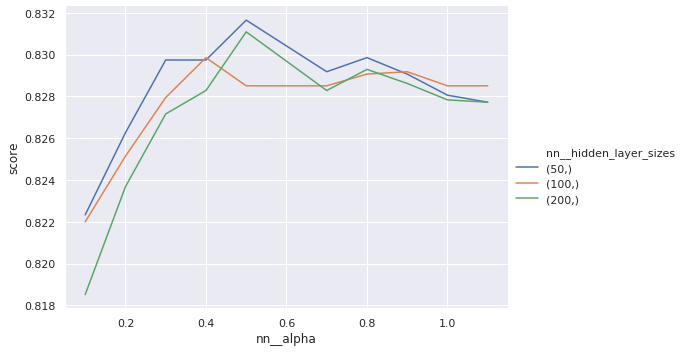

In [46]:
g = sns.relplot("nn__alpha", "score", "nn__hidden_layer_sizes",
                data=df_nn, kind="line", height=5, aspect=1.5, 
                ci=None)

With neural networks, or xgb or any classifier built on many individual models, it is useful to change the random_state to see how different the plot is.  Although not shown here, the above plot was similar to those which used a different random_state.

## Stacking with Optimized Base Learners

### Instantiate Base Learners

In [47]:
idx = df_lr['score'].idxmax()
c = df_lr['lr__C'][idx]

lr_best = LogisticRegression(penalty='l2', solver='liblinear', C=c)
lr_pipe_best = Pipeline([('ct', ct), ('lr', lr_best)])

In [48]:
idx = df_svm['score'].idxmax()
gamma = df_svm['svm__gamma'][idx]
c = df_svm['svm__C'][idx]

svm_best = SVC(gamma=gamma, C=c, probability=True)
svm_pipe_best = Pipeline([('ct', ct), ('svm', svm_best)])

In [49]:
idx = df_knn['score'].idxmax()
n_neighbors = df_knn['knn__n_neighbors'][idx]
p = df_knn['knn__p'][idx]

weights = df_knn['knn__weights'][idx]
knn_best = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
knn_pipe_best = Pipeline([('ct', ct), ('knn', knn_best)])

In [50]:
idx = df_xgb['score'].idxmax()
colsample_bytree = df_xgb['colsample_bytree'][idx]
learning_rate = df_xgb['learning_rate'][idx]
max_depth = df_xgb['max_depth'][idx]
n_estimators = df_xgb['n_estimators'][idx]

xgb_best = XGBClassifier(n_estimators=n_estimators, 
                         learning_rate=learning_rate,
                         colsample_bytree=colsample_bytree, 
                         max_depth=max_depth,
                         random_state=48)

In [51]:
idx = df_nn['score'].idxmax()
hidden_layer_sizes = df_nn['nn__hidden_layer_sizes'][idx]
alpha = df_nn['nn__alpha'][idx]

nn_best = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha,
                       max_iter=2000, random_state=909)
nn_pipe_best = Pipeline([('ct', ct), ('nn', nn_best)])

#### Verify Accuracy of Optimized Base Learners

In [52]:
# Evaluate the Accuracy of each base learner
base_learners = [lr_pipe_best, knn_pipe_best, xgb_best, 
                 svm_pipe_best, nn_pipe_best]

for base_learner in base_learners:
    if hasattr(base_learner, 'steps'):
        name = base_learner.steps[1][0].upper()
    else:
        name = base_learner.__class__.__name__
        
    scores  = cross_val_score(base_learner,  X, y, scoring='accuracy', cv=cv_select)
    print(f'{name:13} Score: {scores.mean():.3f} +/- {scores.std():.3f}')

LR            Score: 0.832 +/- 0.014
KNN           Score: 0.824 +/- 0.015
XGBClassifier Score: 0.833 +/- 0.014
SVM           Score: 0.834 +/- 0.014
NN            Score: 0.832 +/- 0.016


### Experiment

#### Base Learners: LogitReg, SVC, XGB

In [53]:
base_learners = [lr_pipe_best, svm_pipe_best, xgb_best]
meta_learner = LogisticRegression(solver='liblinear')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.859
CV Mean Score: 0.834 +/- 0.012


#### Base Learners: LogitReg, SVC, KNN, XGB

In [54]:
base_learners = [lr_pipe_best, svm_pipe_best, knn_pipe_best, xgb_best]
meta_learner = LogisticRegression(solver='liblinear')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.857
CV Mean Score: 0.835 +/- 0.011


#### Base Learners: LogitReg, SVC, KNN, XGB, NeuralNetwork

In [55]:
base_learners = [lr_pipe_best, svm_pipe_best, knn_pipe_best, 
                 xgb_best, nn_pipe_best]
meta_learner = LogisticRegression(solver='liblinear')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.816 max:0.859
CV Mean Score: 0.835 +/- 0.012


#### Analysis of Results

The best base learner is SVM with a score of 0.834 +/- 0.014.  The best stacked estimator had a score of 0.835 +/- 0.012.

This is improvement is not significant.

## Stacking with Optimized Meta Learner and Optimized Base Learners
The meta leaner will be tuned for use with the optimized LogitReg, SVM, KNN and XGB base learners.

To keep the custom StackingClassifier code simple, it was not created to work with GridSearchCV.  

Scikit Learn has a nice helper function which turns a parameter dictionary used by GridSearchCV into an iterator of dictionaries.  This makes it easy to use a for-loop to find the scores at each point on the grid.

In [56]:
# wide range of values to see shape
c_values = np.logspace(np.log10(.0005), -1, 5)

# narrower range of values to home in on optimal point
c_values = np.append(c_values, np.logspace(np.log10(.0027), 
                                           np.log10(.0130), 7))

c_values = np.sort(c_values)

In [57]:
from sklearn.model_selection import ParameterGrid

# try ParameterGrid
params = {'C': c_values}
for param in ParameterGrid(params):
    print(param)

{'C': 0.0004999999999999999}
{'C': 0.0018803015465431966}
{'C': 0.0027}
{'C': 0.0035085448203514722}
{'C': 0.004559217317190799}
{'C': 0.005924525297439448}
{'C': 0.0070710678118654745}
{'C': 0.0076986898316194294}
{'C': 0.010004147530452184}
{'C': 0.013}
{'C': 0.026591479484724942}
{'C': 0.1}


In [58]:
meta_learner = LogisticRegression(solver='liblinear')
base_learners = [lr_pipe_best, svm_pipe_best, knn_pipe_best, xgb_best]
params = {'C': c_values}

results = []
for param in ParameterGrid(params):
    meta_learner = LogisticRegression(solver='liblinear', **param)
    sc = StackedClassifier(base_learners, meta_learner, cv_predict)
    scores = cross_val_score(sc, X, y, cv=cv_select)
    c = param['C']
    score = scores.mean()
    sd = scores.std()
    results.append({'C': c, 'score': score, 'sd': sd})
    print(f'C: {c:7.5f} score {score:6.4f} +/- {sd:6.4f}')       

results = pd.DataFrame(results)

C: 0.00050 score 0.8349 +/- 0.0122
C: 0.00188 score 0.8359 +/- 0.0127
C: 0.00270 score 0.8361 +/- 0.0124
C: 0.00351 score 0.8366 +/- 0.0127
C: 0.00456 score 0.8364 +/- 0.0124
C: 0.00592 score 0.8366 +/- 0.0133
C: 0.00707 score 0.8365 +/- 0.0129
C: 0.00770 score 0.8364 +/- 0.0128
C: 0.01000 score 0.8362 +/- 0.0134
C: 0.01300 score 0.8362 +/- 0.0133
C: 0.02659 score 0.8351 +/- 0.0128
C: 0.10000 score 0.8347 +/- 0.0126


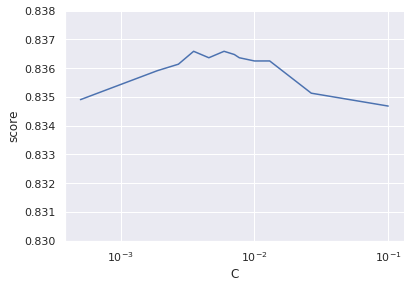

In [59]:
g = sns.relplot("C", "score", data=results,
                kind="line", height=4.0, aspect=1.5)
ax = g.axes[0,0]
ax.set_xscale('log')
ax.set_ylim(0.830, 0.838);

### Analysis of Results
From the above plot, it appears the local maxima has been reached.

The 4 base learners are very different types of classifiers, so they are probably providing diverse predictions.

Using the individually optimized base learners with the individually optimized meta-learner, gave the best result found so far, .837 +/- .013. However given the margin of error, this is not significantly better than previous models.

As per the introductory notebook, the term "significant" is used loosely and does not correspond to a precise alpha value.

## Voting Classifier
The [voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) is similar to the stacked classifier, except that the meta learner makes use the sum of the probabilities (voting=soft) or the sum of the class label predictions (voting=hard) for each of its base learners.

From the documentation:
> voting : str, {‘hard’, ‘soft’} (default=’hard’)
If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

A "well-calibrated classifier" is one in which the probabilities have been tuned to be more accurate.  This requires a hold-out set for the probability tuning and the Titanic data set is too small for an additional hold-out set.

### Experiment with VotingClassifier Ensembles

#### LogitReg, SVM

In [60]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best)], 
                      voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.852
CV Mean Score: 0.833 +/- 0.014


In [61]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best)], 
                      voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.812 max:0.859
CV Mean Score: 0.834 +/- 0.015


#### LogitReg, SVM, XGB

In [62]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best)], voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.816 max:0.863
CV Mean Score: 0.835 +/- 0.014


In [63]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.854
CV Mean Score: 0.834 +/- 0.012


#### LogitReg, SVM, XGB, KNN

In [64]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('knn', knn_pipe_best)],
                       voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.857
CV Mean Score: 0.836 +/- 0.012


In [65]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.854
CV Mean Score: 0.834 +/- 0.012


#### LogitReg, SVM, XGB, NeuralNetwork

In [66]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('nn', nn_pipe_best)], 
                       voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.861
CV Mean Score: 0.834 +/- 0.014


In [67]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('nn', nn_pipe_best)], 
                       voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.816 max:0.861
CV Mean Score: 0.836 +/- 0.014


#### LogitReg, SVM, XGB, NeuralNetwork

In [68]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('nn', nn_pipe_best)], 
                      voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.861
CV Mean Score: 0.834 +/- 0.014


In [69]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('nn', nn_pipe_best)], 
                      voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.816 max:0.861
CV Mean Score: 0.836 +/- 0.014


#### LogitReg, SVM, KNN, XGB, NeuralNetwork

In [70]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('knn', knn_pipe_best), ('xgb', xgb_best),
                       ('nn', nn_pipe_best)], voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.859
CV Mean Score: 0.834 +/- 0.014


In [71]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('knn', knn_pipe_best), ('xgb', xgb_best),
                       ('nn', nn_pipe_best)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.813 max:0.858
CV Mean Score: 0.835 +/- 0.013


### Analysis of Results
More experiments were tried than are presented above, but the above results are illustrative of what happened.

The VotingClassifier's best results were similar to the Stacking estimator's best results.  None of these are significantly better than using an out-of-the-box LogisticRegression or SVC classifier, with the appropriately preprocessed data.

## Custom Forest of Trees
The following is an example of creating a forest of decision trees.

Normally a forest should be created with XGBoost or a Scikit Learn estimator such as RandomForest.

The intent of this example is to show that it is possible to produce a reasonable classifier out of decision trees with just two ideas:
1. Each tree should be diverse
2. Each tree should be better than average

In [72]:
# copied from titanic_help_code.py
def get_ct_bycolumn(cols):
    """Column Transform for Features

    """

    ii = WrappedIterativeImputer('Age')

    # Pipelines
    ii_pipe = Pipeline([('ii', ii)])

    # Columns to act on
    ii_cols = ['Pclass', 'Sex', 'Age', 'Title_Master',
                  'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']

    if 'Age' in cols:
        # cols.remove is an inplace operation
        # which operates on a reference
        cols = cols.copy()
        cols.remove('Age')
        transformers = [('ii_tr', ii_pipe, ii_cols),
                        ('as_is', 'passthrough', cols)]
        return_cols = ['Age'] + cols
    else:
        transformers = [('as_is', 'passthrough', cols)]
        return_cols = cols

    ct = ColumnTransformer(transformers=transformers)

    return return_cols, ct

In [73]:
X.columns.to_list()

['Pclass',
 'Sex',
 'Age',
 'Fare',
 'family_size',
 'is_cabin_notnull',
 'Port_C',
 'Port_Q',
 'Port_S',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Other']

When XGB was tuned above, colsample_bytree was optimized at 0.50.  This suggests that half of the features should be used at any given time.

Tree diversity will be ensured by using all possible combinations of 14 fields taken 7 at a time. 

In [74]:
# get all possible combinations of the 14 fields taken 7 at a time
import itertools
subsets = list(itertools.combinations(X.columns, r=7))
len(subsets)

3432

### Python Multiprocesing
The idea is to create 3432 DecisionTrees, cross validate each tree, and use the best half in a VotingClassifier.

cross_val_score can be used with n_jobs=-1, however for a single decision tree, this is too small a unit-of-work.  Each fold is parallelized, but the execution time per fold, per DecisionTree, is very small.

As 20 folds are being evaluated (10-Repeated 2-Fold CV), processing each cross_val_score with n_job=1, will result in a unit-of-work that is 20 times larger.  If each cross_val_score is run in parallel from a Python multiprocessing pool, then the throughput will be higher.

Below [imap_unordered](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool.imap_unordered) is used.  This allows each process in the process pool to call a function on an iterator of arguments.  Here the function is eval_tree, and the iterator is a list of tuples of column names.

Below [tqdm](https://github.com/tqdm/tqdm) is used.  This is very handy progress bar.  It shows how much time has elapsed and estimates how much time remains and works well with imap_unordered.

#### Scikit Learn Multprocessing
With version 0v21.2 of Scikit Learn, leaving n_jobs unspecified is an excellent default.  On my machine, I see parallelization taking place according at the highest level of Scikit Learn method used, and with all 4 cores. This is optimal.

Specifying n_jobs=-1 say in a ColumnTransformer, is not helpful if this is called from within cross_val_score or GridSearchCV (or from within GridSearchCV which itself is called from within cross_val_Score).  The parallelization works best at the highest level only.

Had my ColumnTransform function (get_ct) specified n_jobs, then when it was called by another Scikit Learn function that uses multiprocessing, it could have slowed down the processing (due to locking and oversubscription).  By not specifying n_jobs at all, Scikit Learn knows to parallelize at the cross_val_score or GridSearchCV level only.  Furthermore it knows to use all 4 cores on my computer running Ubuntu 18.04.2 LTS.

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_validate

In [76]:
def eval_tree(s):
    """Create Decision Tree with Specified Columns and
    cross validate according to several metrics"""
    
    # s is a tuple of columns created by itertools.combinations
    # whereas get_ct_bycolumn needs a list of columns
    cols_returned, ct = tt.get_ct_bycolumn(list(s))    
    dtree = DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    scores = cross_validate(pipe, X, y, cv=cv_select, n_jobs=1,
                            scoring=('accuracy', 
                                     'brier_score_loss',
                                     'f1',
                                     'roc_auc',
                                     'neg_log_loss'))
    return (scores['test_accuracy'].mean(),
            scores['test_brier_score_loss'].mean(),
            scores['test_f1'].mean(),
            scores['test_roc_auc'].mean(),
            scores['test_neg_log_loss'].mean(),
                 s)

In [77]:
import multiprocessing as mp
import tqdm
import time

# this computer has 4 cores (8 threads with hyperthreading)
pool = mp.Pool(4)

start = time.time()
scores = list(tqdm.tqdm(
    pool.imap_unordered(eval_tree, subsets, chunksize=1), 
              total=len(subsets)))
stop = time.time()

100%|██████████| 3432/3432 [24:18<00:00,  2.35it/s]


In [78]:
print(f'Time: {stop-start:7.1f}')
pool.close()
pool.join()

Time:  1458.1


In [79]:
scores_df = pd.DataFrame(scores, columns=['acc', 'brier', 'f1', 
                                          'roc_auc', 'log_loss',
                                          'vars'])
scores_df.nlargest(n=5, columns=['acc'])

,acc,brier,f1,roc_auc,log_loss,vars
750,0.823458,-0.134875,0.731260,0.852370,-0.715981,"(Pclass, Sex, Port_C, Port_Q, Title_Master, Ti..."
739,0.823347,-0.135169,0.731198,0.852394,-0.734723,"(Pclass, Sex, Port_C, Port_Q, Port_S, Title_Ma..."
2479,0.823341,-0.141747,0.759128,0.849934,-1.213587,"(Sex, family_size, is_cabin_notnull, Port_Q, T..."
737,0.823233,-0.135418,0.731354,0.852025,-0.749785,"(Pclass, Sex, Port_C, Port_Q, Port_S, Title_Ma..."
744,0.822785,-0.136033,0.730518,0.850302,-0.779882,"(Pclass, Sex, Port_C, Port_Q, Port_S, Title_Mr..."


In [80]:
# save it to avoid redoing the above long running operation
# scores_df.to_csv('data/tree_scores.csv', index=False)

### Create Forests of Decision Trees
In the following, the best half of the decision trees, as per the particular scoring metric, are used to create a Forest of Decision Trees.  Each forest will be used at the base learners for a VotingClassifier which has its cross validated score computed using both hard and soft voting.

In [81]:
for metric in ['acc', 'brier', 'f1', 'roc_auc', 'log_loss']:
    best = scores_df.nlargest(n=len(subsets)//2, columns=metric)
    
    # instantiate each tree
    best_trees = []
    for i, s in enumerate(best['vars']):
        cols_returned, ct = tt.get_ct_bycolumn(list(s))    
        dtree = DecisionTreeClassifier(random_state=707)
        pipe = Pipeline([('ct', ct), ('dtree', dtree)])
        best_trees.append((f'{i}', pipe))
        
    # try hard and soft voting with each
    print(metric, 'hard voting')
    vc = VotingClassifier(best_trees, voting='hard')
    scores = cross_val_score(vc, X, y, cv=cv_select)
    tt.print_scores(scores)
    
    print(metric, 'soft voting')
    vc = VotingClassifier(best_trees, voting='soft')
    scores = cross_val_score(vc, X, y, cv=cv_select)
    tt.print_scores(scores)
    print()

acc hard voting
20 Scores  min:0.803 max:0.861
CV Mean Score: 0.833 +/- 0.015
acc soft voting
20 Scores  min:0.809 max:0.863
CV Mean Score: 0.832 +/- 0.014

brier hard voting
20 Scores  min:0.800 max:0.859
CV Mean Score: 0.833 +/- 0.015
brier soft voting
20 Scores  min:0.813 max:0.859
CV Mean Score: 0.831 +/- 0.012

f1 hard voting
20 Scores  min:0.798 max:0.861
CV Mean Score: 0.833 +/- 0.015
f1 soft voting
20 Scores  min:0.814 max:0.852
CV Mean Score: 0.831 +/- 0.011

roc_auc hard voting
20 Scores  min:0.800 max:0.861
CV Mean Score: 0.833 +/- 0.014
roc_auc soft voting
20 Scores  min:0.814 max:0.857
CV Mean Score: 0.832 +/- 0.011

log_loss hard voting
20 Scores  min:0.798 max:0.861
CV Mean Score: 0.832 +/- 0.015
log_loss soft voting
20 Scores  min:0.814 max:0.857
CV Mean Score: 0.831 +/- 0.012



All of the scoring methods produced forests which almost the same score.  
Hard voting was slightly better than soft voting in every case.  
The scores are good, but not significantly better than previous models.

### Experiment: Best per Multiple Scoring Criteria
Try creating a forest in with trees that are in the top 50% for all 5 metrics.

In [82]:
scores_df.shape

(3432, 6)

In [83]:
best_critiera = \
(scores_df['acc'] > scores_df['acc'].median()) & \
(scores_df['brier'] > scores_df['brier'].median()) & \
(scores_df['f1'] > scores_df['f1'].median()) & \
(scores_df['roc_auc'] > scores_df['roc_auc'].median()) & \
(scores_df['log_loss'] > scores_df['log_loss'].median())

best = scores_df[best_critiera]
best.shape

(1377, 6)

In [84]:
# instantiate each tree and place them in a list
best_trees = []
for i, s in enumerate(best['vars']):
    cols_returned, ct = tt.get_ct_bycolumn(list(s))    
    dtree = DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    best_trees.append((f'{i}', pipe))

In [85]:
vc = VotingClassifier(best_trees, voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.812 max:0.865
CV Mean Score: 0.835 +/- 0.014


### Custom Forest Results

The above forest is very good, but still not significantly better than the default LogisticRegression model used with appropriate data preprocessing.

A good ensemble classifier was created for this data set simply by:
1. creating a default DecisionTree for each combination of half of the variables
2. creating a collection of trees from the top 50% best trees created in step 1, as per their cross validated score 

In practice, XGBoost or similar should be used for a forest of trees.

# Notebook Summary

Several ensemble methods were tried:
* Stacking via a custom coded Stacking estimator
* VotingClassifier
* Forest of Trees via a custom coded collection of decision trees

For Stacking and Voting, each individual base learner was optimized.  For Stacking the meta learner was also optimized.

Stacking, Voting, and the custom Forest all did well, but did not improve upon the score from previous models.

The Titanic data set is small and simple.  In the next notebook, a single small DecisionTree which is both easy to interpret and predicts well on the Titanic data will be created.  The fact that a single small DecisionTree can do well, suggests that techniques such as hyperparameter optimization and ensembles, were overkill for such a simple problem.

On Kaggle, some people have scored above 85% accuracy for the Titanic data set.  It is likely these people custom coded their classifier specifically to match the answer.  The hold-out set on Kaggle, [test.csv](https://www.kaggle.com/c/titanic/data), has target values which can be found elsewhere on the Internet, making it possible to cheat.  Others who scored above 85% may have chosen a single train/test split and simply got lucky on the how that split was created.  For a data set as small as the Titanic, repeated cross validation needs to be used to produce a repeatable score (with different random_state values).